CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [44]:
!pip install captum

In [45]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [46]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')

categorical_columns = ['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range']
continuous_columns = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
target_columns = ['resale_price']

# TODO: Enter your code here
df_train = df[df['year'] <= 2019]
df_val = df[df['year'] == 2020]
df_test = df[df['year'] == 2021]

df_train = df_train.drop(categorical_columns, axis=1)
df_val = df_val.drop(categorical_columns, axis=1)
df_test = df_test.drop(categorical_columns, axis=1)

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [47]:
# TODO: Enter your code here
# Hyperparameter used throughout the code
BATCH_SIZE = 64
NUM_EPOCHS = 100

# Helper function to create DataLoader
def create_dataloader(df, target_columns, batch_size):
    # Extract values from dataframes
    X = df.drop(target_columns, axis=1).values
    y = df[target_columns].values

    # Convert values to tensors for the model
    X = torch.tensor(X).float()
    y = torch.tensor(y).view(-1, 1).float()

    # Create custom DataLoader
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return X, y, dataloader

# Create DataLoaders for each dataset
X_train, y_train, dataloader_train = create_dataloader(df_train, target_columns, BATCH_SIZE)
X_val, y_val, dataloader_val = create_dataloader(df_val, target_columns, BATCH_SIZE)
X_test, y_test, dataloader_test = create_dataloader(df_test, target_columns, BATCH_SIZE)

In [48]:
# Define model parameters
input_size = df_train.shape[1]-1
output_size = 1
size_hidden = 5

class HDBRegressionModel(nn.Module):
    def __init__(self):
        super(HDBRegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, output_size)
        )

    def forward(self, input):
        return self.layers(input)

In [49]:
model = HDBRegressionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [50]:
def train(model, optimizer, loss_fn, num_epochs, dataloader):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model parameters
            running_loss += loss.item()

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss:.3f}')

# Usage
train(model, optimizer, loss_fn, num_epochs=NUM_EPOCHS, dataloader=dataloader_train)

Epoch [1/100] Loss: 214910019780608.000
Epoch [10/100] Loss: 14916940846080.000
Epoch [20/100] Loss: 12236809252864.000
Epoch [30/100] Loss: 9354066244864.000
Epoch [40/100] Loss: 6420225574912.000
Epoch [50/100] Loss: 5698280052736.000
Epoch [60/100] Loss: 5594485211392.000
Epoch [70/100] Loss: 5520178246656.000
Epoch [80/100] Loss: 5463813907200.000
Epoch [90/100] Loss: 5418291720448.000
Epoch [100/100] Loss: 5344059545088.000


In [51]:
# Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

no_of_test_instances = 1000 # Takes too long to use all the test instances
sl_attr_test = sl.attribute(X_test[:no_of_test_instances])
ixg_attr_test = ixg.attribute(X_test[:no_of_test_instances])
ig_attr_test = ig.attribute(X_test[:no_of_test_instances], n_steps=50)
gs_attr_test = gs.attribute(X_test[:no_of_test_instances], X_train)
fa_attr_test = fa.attribute(X_test[:no_of_test_instances])

C:\Users\alpha\anaconda3\envs\cz4042_helpme\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


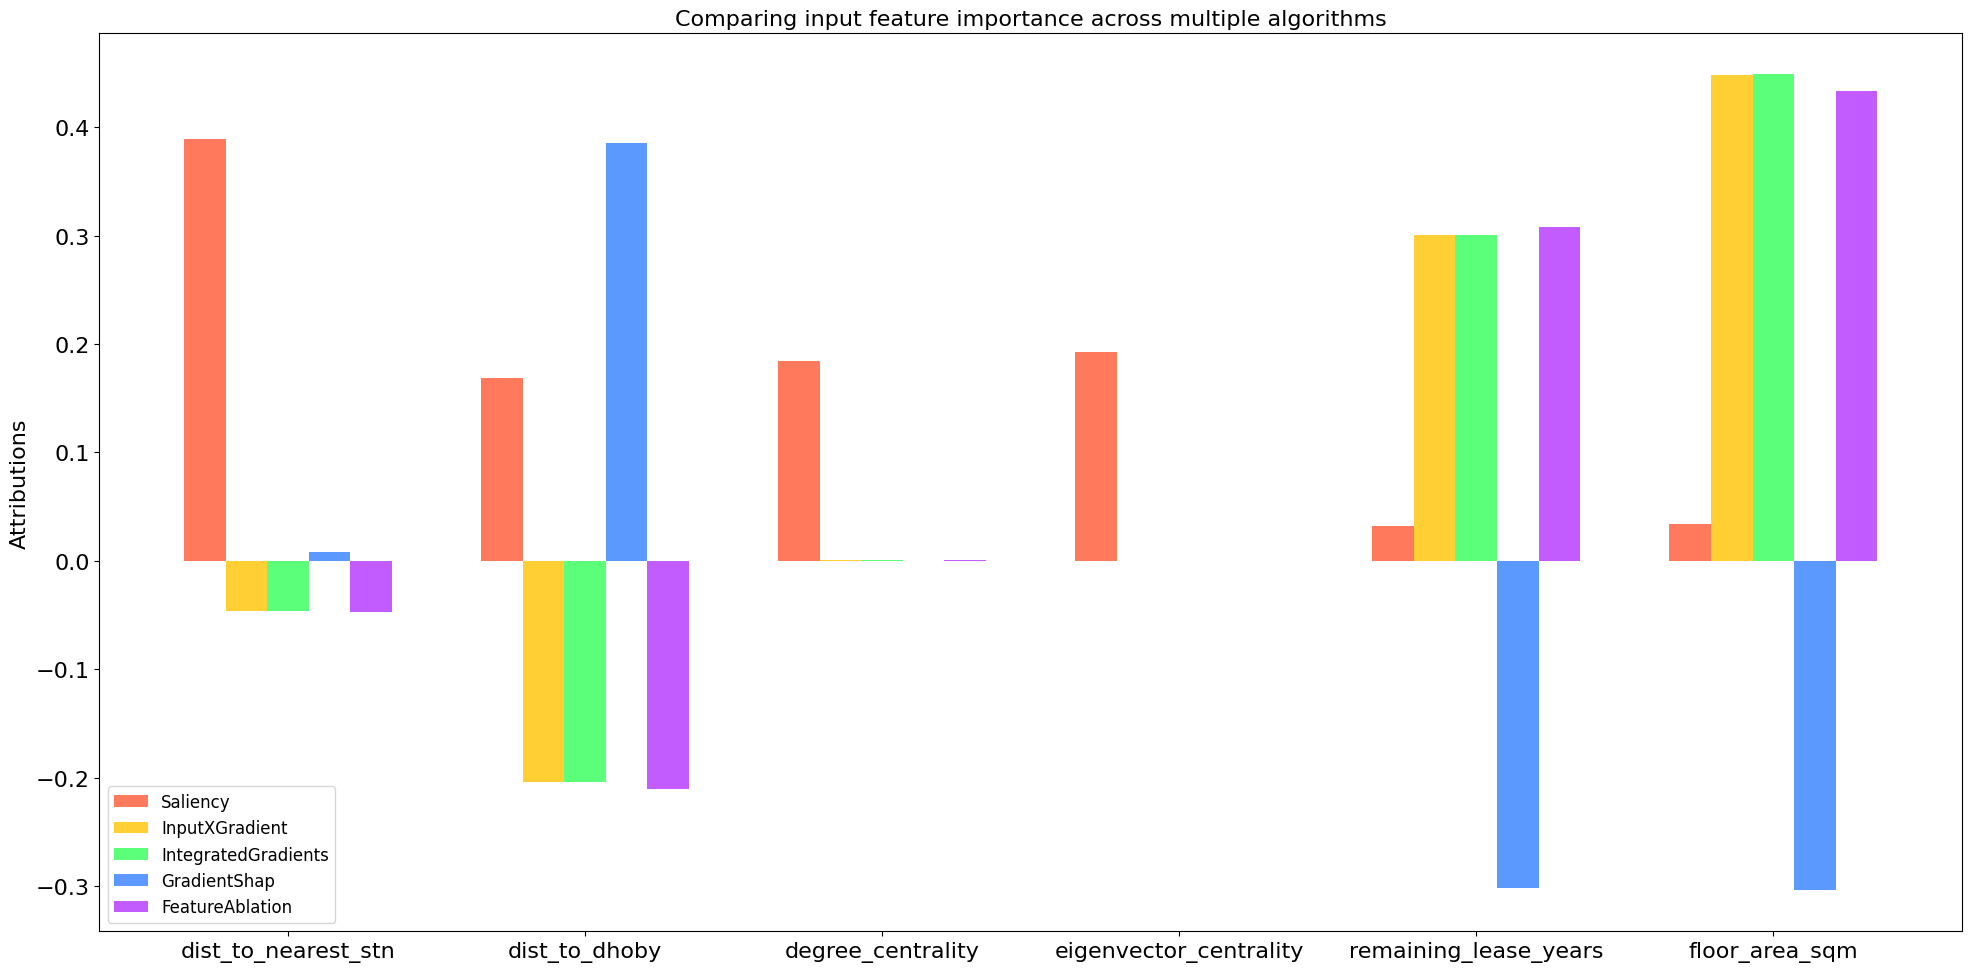

In [52]:
import matplotlib.pyplot as plt

def calculate_normalized_sums(attr):
    attr_sum = attr.detach().numpy().sum(0)
    normalized_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    return normalized_sum

def plot_attributions(x_axis_data, x_axis_data_labels, attr_data, legends, title, ylabel):
    width = 0.14
    plt.figure(figsize=(20, 10))
    ax = plt.subplot()

    ax.set_title(title)
    ax.set_ylabel(ylabel)

    FONT_SIZE = 16
    plt.rc('font', size=FONT_SIZE)
    plt.rc('axes', titlesize=FONT_SIZE)
    plt.rc('axes', labelsize=FONT_SIZE)
    plt.rc('legend', fontsize=FONT_SIZE - 4)

    for i, (attr, legend, color) in enumerate(zip(attr_data, legends, ['#FF5733', '#FFC300', '#33FF57', '#3380FF', '#B533FF'])):
        ax.bar(x_axis_data + i * width, attr, width, align='center', alpha=0.8, label=legend, color=color)

    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data + (width * (len(legends) - 1) / 2))
    ax.set_xticklabels(x_axis_data_labels)

    plt.legend(loc=3)
    plt.show()

# prepare attributions for visualization
feature_names = df_train.drop(target_columns, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

attr_data = [calculate_normalized_sums(attr) for attr in [sl_attr_test, ixg_attr_test, ig_attr_test, gs_attr_test, fa_attr_test]]

# Plotting
legends = ['Saliency', 'InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation']
plot_attributions(x_axis_data, x_axis_data_labels, attr_data, legends, 'Comparing input feature importance across multiple algorithms', 'Attributions')

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [53]:
from sklearn.preprocessing import StandardScaler

# Define a function for scaling data
def scale_data(scaler, data):
    scaled_data = scaler.transform(data)
    return torch.tensor(scaled_data).float()

# Create StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = torch.tensor(X_train_scaled).float()

# Scale the data
X_val_scaled = scale_data(scaler, X_val)
X_test_scaled = scale_data(scaler, X_test)

# Create custom DataLoaders for scaled data
datasets = {
    'train': torch.utils.data.TensorDataset(X_train_scaled, y_train),
    'val': torch.utils.data.TensorDataset(X_val_scaled, y_val),
    'test': torch.utils.data.TensorDataset(X_test_scaled, y_test)
}

dataloaders = {key: torch.utils.data.DataLoader(datasets[key], batch_size=BATCH_SIZE, shuffle=True) for key in datasets}

# Create model, optimizer, and loss functions
model = HDBRegressionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train the model on scaled data
train(model, optimizer, loss_fn, num_epochs=NUM_EPOCHS, dataloader=dataloaders['train'])

Epoch [1/100] Loss: 216505334972416.000
Epoch [10/100] Loss: 150227372662784.000
Epoch [20/100] Loss: 43525890963456.000
Epoch [30/100] Loss: 12840795182592.000
Epoch [40/100] Loss: 5822527534592.000
Epoch [50/100] Loss: 4990906207232.000
Epoch [60/100] Loss: 4728055095296.000
Epoch [70/100] Loss: 4508050939136.000
Epoch [80/100] Loss: 4332401729024.000
Epoch [90/100] Loss: 4189799928576.000
Epoch [100/100] Loss: 4074644016256.000


C:\Users\alpha\anaconda3\envs\cz4042_helpme\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


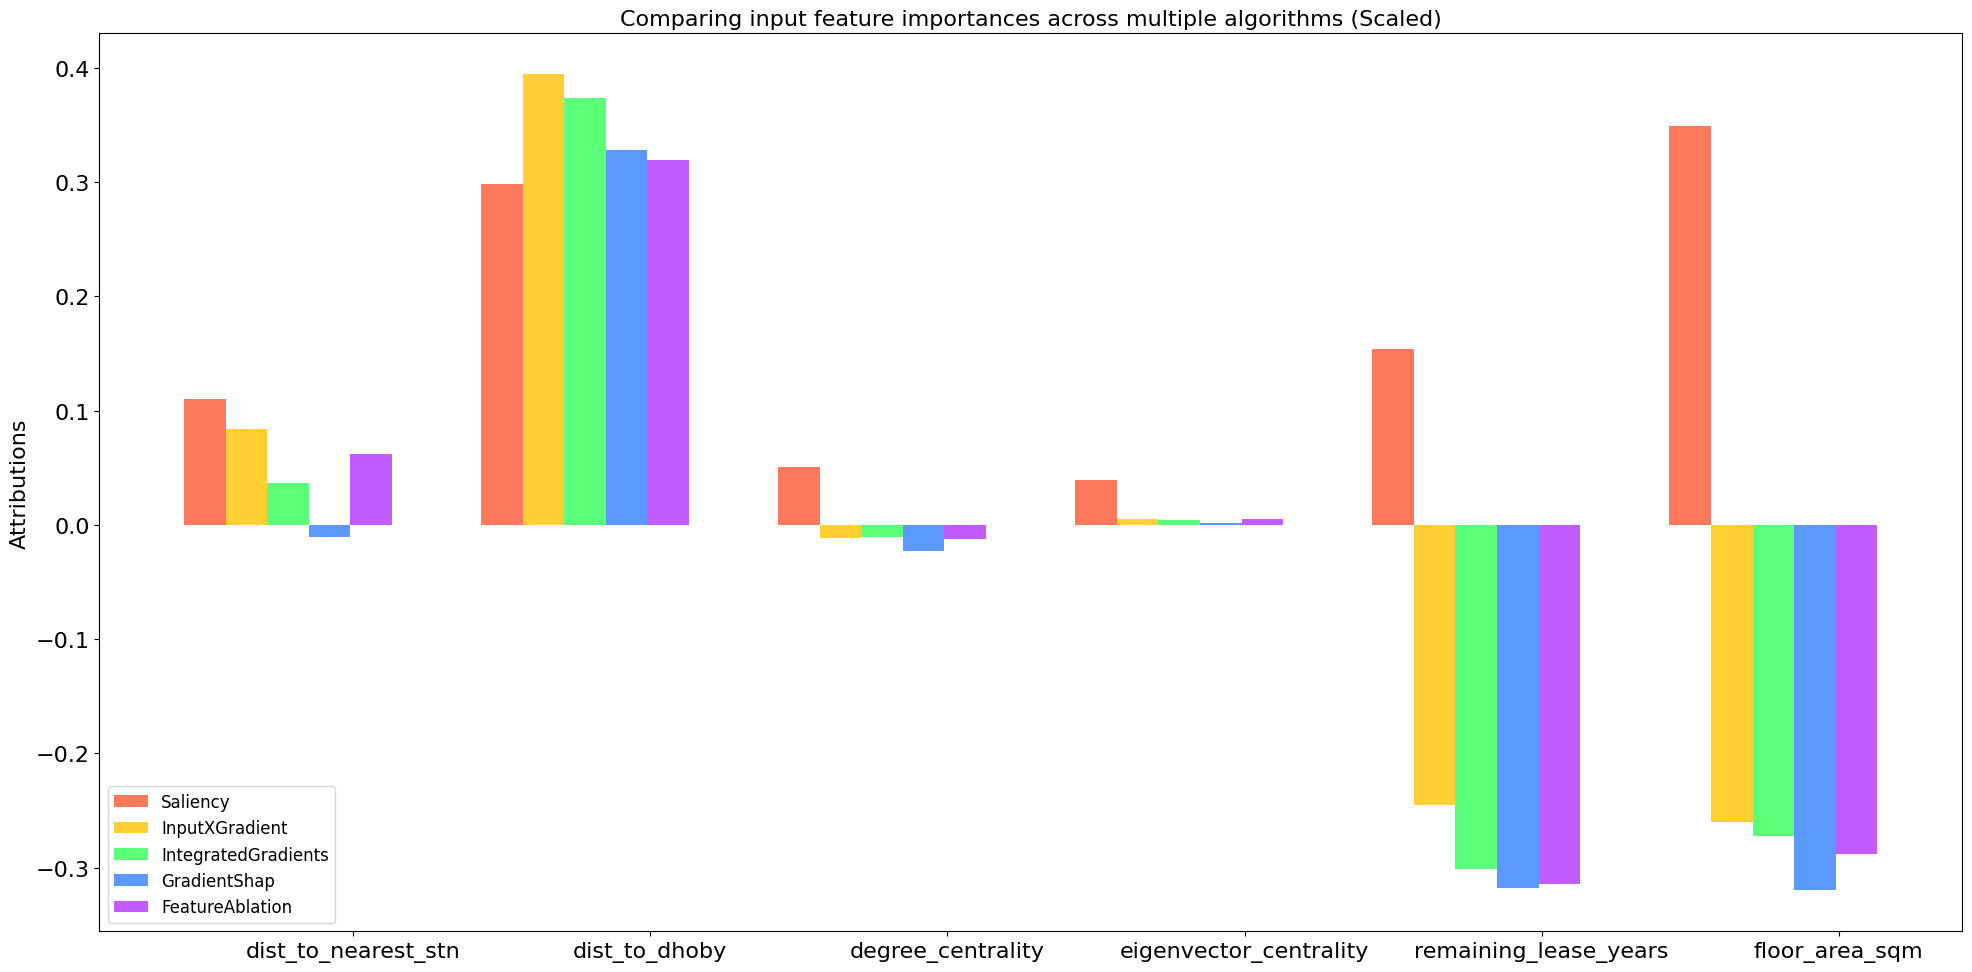

In [54]:
# Attribution methods
attribution_methods = [Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation]
attributions = {method.__name__: method(model) for method in attribution_methods}

# Number of test instances
no_of_test_instances = 1000

# Compute attributions for each method
for method in attribution_methods:
    if method.__name__ == 'IntegratedGradients':
        attributions[method.__name__] = method(model).attribute(X_test_scaled[:no_of_test_instances], n_steps=50)
    elif method.__name__ == 'GradientShap':
        attributions[method.__name__] = method(model).attribute(X_test_scaled[:no_of_test_instances], X_train_scaled)
    else:
        attributions[method.__name__] = method(model).attribute(X_test_scaled[:no_of_test_instances])

# Prepare attributions for visualization
feature_names = df_train.drop(target_columns, axis=1).columns
x_axis_data = np.arange(X_test_scaled.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

# Compute normalized sums for each method
normalized_sums = {method_name: attr.detach().numpy().sum(0) / np.linalg.norm(attr.detach().numpy().sum(0), ord=1)
                   for method_name, attr in attributions.items()}

# Plotting
width = 0.14
legends = list(attributions.keys())

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.set_title('Comparing input feature importances across multiple algorithms (Scaled)')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)
colour = ['#FF5733', '#FFC300', '#33FF57', '#3380FF', '#B533FF']
for i, method_name in enumerate(legends):
    ax.bar(x_axis_data + i * width, normalized_sums[method_name], width, align='center', alpha=0.8,
           label=method_name, color=colour[i])

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(loc=3)
plt.show()

After standardization, it is observed that each feature exhibits a greater influence on the final output, as indicated by the heightened magnitude of the GradientSHAP values.

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


My results do not exhibit consistent scores for Saliency and Integrated Gradients (IG). However, a possible reason
why both would produce similar scores is due to the shared reliance on gradient information.

Saliency computes the gradients of the model's outputs with respect to input features, while IG involves integrating these gradients along a specific path, often a straight line from a baseline to the input of interest, while also scaling them by the difference between the input and baseline. Consequently, in our dataset, if the chosen path in IG aligns closely with the direction of significant change traversed by Saliency, it may lead to similar results.

> Why did Input x Gradients give the same attribution scores as IG?


The similarity in attribution scores between Input x Gradients (IxG) and Integrated Gradients (IG) in our dataset can be ascribed to their common fundamental principle.

Both IxG and IG provide a measure of how individual features influence the model's output. IxG accomplishes this by multiplying the gradients of the model's output with respect to the input features by the input values themselves, while IG calculates the integral of gradients along the path from the baseline to the input.

In the context of our dataset, when the input values and gradients exhibit similar magnitudes or are aligned in a manner that accentuates the impact of specific features, it is likely that IxG and IG will yield comparable attribution scores.